# OSM Population Prediction Model

## Table of Contents
<ul>
<li><a href="#introduction">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a>
    <ul>
        <li><a href="#gather">Gather</a></li>
        <li><a href="#assess">Assess</a></li>
        <li><a href="#clean">Clean</a></li>
    </ul>
</li>
<li><a href="#feature_engineering">Feature Engineering</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#helpers">Helper Classes and Methods</a></li>
<li><a href="#ml">Model Training</a></li>
<li><a href="#conclusion">Conclusion</a></li>
<li><a href="#references">References</a></li>
</ul>

<a id='introduction'></a>
## Introduction

**How well can we predict the population of a given area based solely on OSM (OpenStreetMap) data?**

In this project we'll try to build a model that can accurately predict the population of a given area, based solely on OSM (OpenStreetMap) data. A model such as this could have several uses in urban planning or traffic modelling for example, and as the OSM data is open source and constanty being updated, it's a free and very accessible data for anyone to easilly use to make predictions. 

The population data we'll be using in this project (taken from reference [1]), comes from Facebook's 
[High Resolution Settlement Layer](https://research.fb.com/downloads/high-resolution-settlement-layer-hrsl/), which estimates the population of a given area using satellite imagery. Performing predictions for new user-defined areas would probably mean having access to the image processing algorithm used in the first place, which very likely is not publicly available, let alone the probably high computing resources required for that task. Therefore, there are obvious advantages of having a model that can make the same kind of predictions with a relatively small set of features, and based only on publicly available data (OSM). This project aims to provide that as an end result.

The features in the data other than the population were taken from OSM by the providers of the dataset (see [1]), altough we don't have a clear description of what they all represent or how they were calculated. For this reason we'll only use features that we know to be OSM features and know the meaning of. The relevant features are thus:

- `count` - total number of OSM objects
- `building_count` - total number of buildings
- `highway_length` - total length of roads / streets
- `osm_users` - number of users that edited the data

The features we won't be using in the model are: `avg_ts`, `max_ts`, `p90_ts`, `local_hours`, `total_hours` and `gdp`.

In order to make the results more extendable and generalized, the features and population of each hexagon are normalized by its respective area. Therefore, what we are actually calculating is the population density (inhabitants / km2) and not the total population.


In [88]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import re
from itertools import product

import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from turf import polygon, area, feature_collection
from scipy.stats import pearsonr
from keplergl import KeplerGl

from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from model.train_model import model_evaluation

In [89]:
# CONFIGURATION

# Set to False if you want to run on the whole data
subset_data = True

all_data_file_name = '../data/hexagons_basic_features.geojson'
sample_data_file_name = '../data/hexagons_basic_features_sample.geojson'

data_file_name = sample_data_file_name if subset_data else all_data_file_name

<a id='wrangling'></a>
## Data Wrangling

In this section we'll load the data, assess it to check for any quality or tidiness issues and clean it where needed.

<a id='gather'></a>
### Gather
As the data was previously gathered from [1], we'll just have to load the geojson as a GeoDataFrame.

In [103]:
df = gpd.read_file(data_file_name)

<a id='assess'></a>
### Assess

In [3]:
map_1 = KeplerGl(height=500)
map_1.add_data(data=df, name="data_1")

map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'data_1': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

In [91]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   count           30000 non-null  float64 
 1   building_count  30000 non-null  float64 
 2   highway_length  30000 non-null  float64 
 3   osm_users       30000 non-null  float64 
 4   population      30000 non-null  float64 
 5   gdp             30000 non-null  float64 
 6   avg_ts          30000 non-null  float64 
 7   max_ts          30000 non-null  float64 
 8   p90_ts          30000 non-null  float64 
 9   area_km2        30000 non-null  float64 
 10  local_hours     30000 non-null  float64 
 11  total_hours     30000 non-null  float64 
 12  one             30000 non-null  float64 
 13  ADMIN           30000 non-null  object  
 14  ISO_A3          30000 non-null  object  
 15  geometry        30000 non-null  geometry
dtypes: float64(13), geometry(1), object(2)
memory usag

We have ~350k (30k if working with sample data) hexagons of roughly 0.65 km2, which are over the United Kingdom.

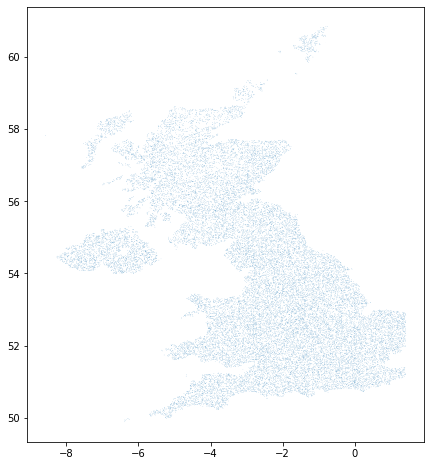

In [92]:
df.plot(figsize=(8, 8))

In [93]:
df[df["population"] == 0].shape

(14397, 16)

In [94]:
df["population"].sum()

5624720.0

In [95]:
for col in df.columns:
    if df[col].nunique() == 1:
        print(col)

one
ADMIN
ISO_A3


In [96]:
df.columns

Index(['count', 'building_count', 'highway_length', 'osm_users', 'population',
       'gdp', 'avg_ts', 'max_ts', 'p90_ts', 'area_km2', 'local_hours',
       'total_hours', 'one', 'ADMIN', 'ISO_A3', 'geometry'],
      dtype='object')

In [97]:
df.building_count.max()

2249.0

In [98]:
df.describe()

,count,building_count,highway_length,osm_users,population,gdp,avg_ts,max_ts,p90_ts,area_km2,local_hours,total_hours,one
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.0
mean,59.767567,22.722833,2748.082590,5.846600,187.490667,7.605145e+06,1.428142e+09,1.503945e+09,1.483739e+09,0.657454,1.565033,3.517433,1.0
std,197.676221,108.547602,3808.151915,7.320036,692.294105,2.817031e+07,2.041692e+08,2.155512e+08,2.131614e+08,0.022386,5.773925,8.318157,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.564214,0.000000,0.000000,1.0
25%,4.000000,0.000000,0.000000,2.000000,0.000000,0.000000e+00,1.409299e+09,1.497544e+09,1.470757e+09,0.643235,0.000000,0.000000,1.0
50%,12.000000,0.000000,1396.439774,4.000000,1.000000,4.078728e+04,1.456850e+09,1.562268e+09,1.534581e+09,0.655987,0.000000,1.000000,1.0
75%,37.000000,4.000000,3736.900642,7.000000,38.000000,1.509129e+06,1.500818e+09,1.580976e+09,1.565769e+09,0.673822,1.000000,4.000000,1.0
max,6289.000000,2249.000000,35529.033086,191.000000,13126.000000,5.353738e+08,1.588034e+09,1.588143e+09,1.588143e+09,0.725685,361.000000,386.000000,1.0


/Users/diogomatoschaves/.conda/envs/osm-population-predictor/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/diogomatoschaves/.conda/envs/osm-population-predictor/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/diogomatoschaves/.conda/envs/osm-population-predictor/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


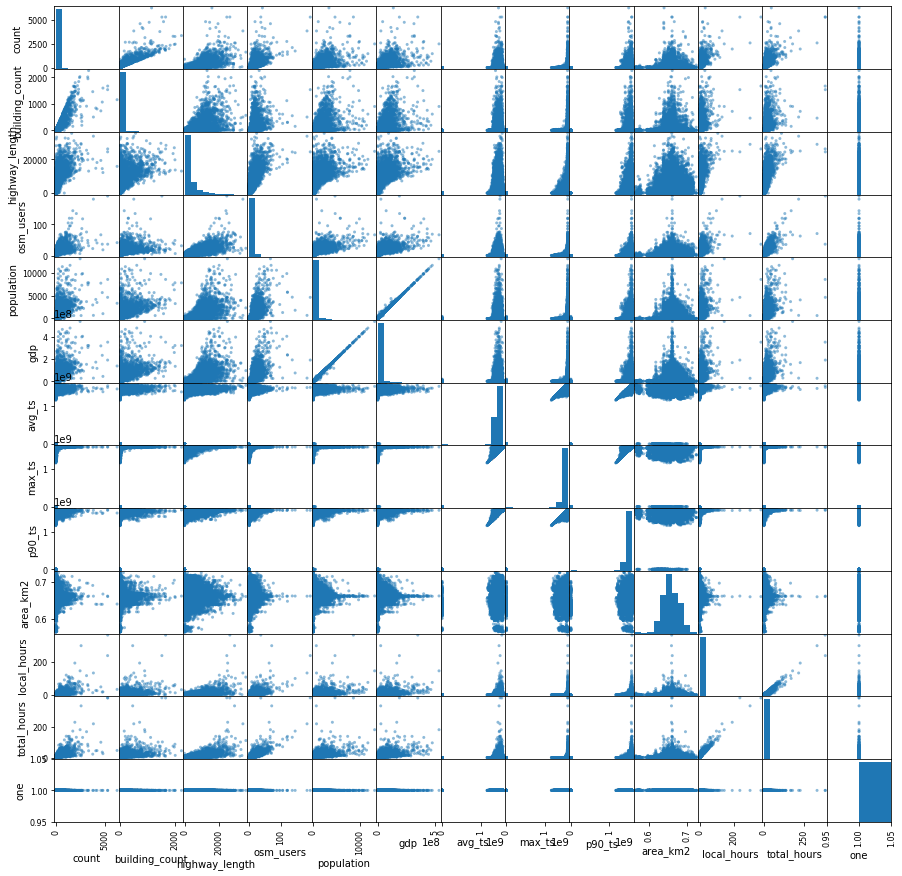

In [99]:
pd.plotting.scatter_matrix(df, figsize=(15, 15));

<a id='clean'></a>
### Clean

We can automatically exclude columns that have only one value, as they won't contribute with any information to our model.

In [104]:
for col in df.columns:
    if df[col].nunique() == 1:
        df.drop(columns=col, inplace=True)

We can rename the variable `area_km2` to `area`.

In [105]:
df.rename(columns={'area_km2': 'area'}, inplace=True)

As we don't really know what some of the variables represent, and also would be difficult to calculate their value for new data, we shall remove them from the analysis. They are `avg_ts`, `max_ts`, `p90_ts`,  `local_hours`, `total_hours`. We can also remove the geometry column, as we won't be needing it anymore.

In [106]:
vars_to_delete = ['avg_ts', 'max_ts', 'p90_ts', 'local_hours', 'total_hours', 'geometry']

df.drop(columns=vars_to_delete, inplace=True)

In order to make the model more general and less prone to overfitting on outliers, we'll apply a rule to delete the data points that are larger or smaller than the 99.9 and 0.1 percentiles respectively. This makes sure that only the relatively extreme values get deleted.

In [108]:
def detect_outliers(column, df=df):
    
    min_value = df[column].quantile(q=0.001)
    max_value = df[column].quantile(q=0.999)
    
    try:
        outliers = df[(df[column] > max_value) | (df[column] < min_value)]
    except IndexError:
        outliers = None
    
    return outliers

In [110]:
outliers = set()

for feature in df.columns:

    new_outliers = detect_outliers(feature)
    
    if new_outliers is None:
        continue
        
    outliers.update(new_outliers.index)

In [111]:
df[df.index.isin(outliers)]

,count,building_count,highway_length,osm_users,population,gdp,area
227,20.0,0.0,0.000000,1.0,0.0,0.000000e+00,0.564926
265,123.0,23.0,6135.384485,32.0,31.0,8.449368e+05,0.718974
406,960.0,435.0,14793.170693,59.0,10612.0,4.328346e+08,0.661061
449,2671.0,189.0,20402.470422,48.0,9749.0,3.976352e+08,0.661542
547,1007.0,381.0,14082.879325,70.0,1844.0,7.521174e+07,0.668865
...,...,...,...,...,...,...,...
29324,6.0,0.0,680.039734,3.0,0.0,0.000000e+00,0.565037
29402,1410.0,615.0,15354.230469,95.0,7682.0,3.133279e+08,0.662315
29413,620.0,249.0,12706.835633,42.0,8388.0,3.421237e+08,0.662789
29541,6.0,1.0,61.989317,4.0,1.0,2.762614e+03,0.724144


In [112]:
df_model = df[~df.index.isin(outliers)]

All features are numeric, so there's no need for performing one hot enconding on any variable. We'll perform feature scaling as a step of the ML pipeline.

<a id='feature_engineering'></a>
## Feature Engineering

In order to make the model more robust, we can include polynomial terms. This will be done as a step of the ML pipeline.

<a id='eda'></a>
## Exploratory Data Analysis

In this section we'll visualize some plots and graphs to help us get a better grasp of the data at hand. We'll start by visualising the correlation between all variables and the target variable - `population`.

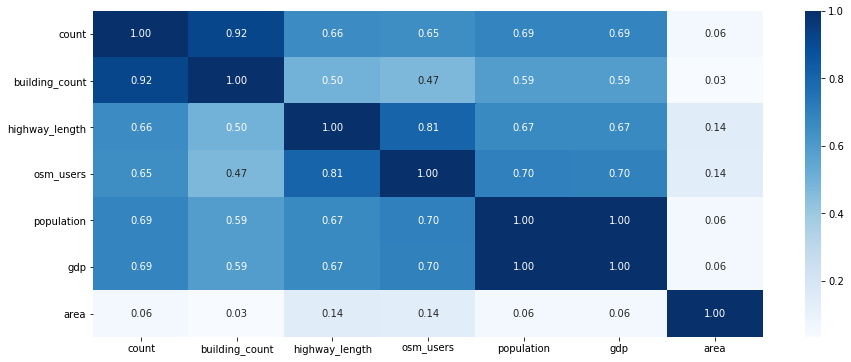

In [117]:
plt.figure(figsize=(15, 6))
sb.heatmap(df_model.corr(), annot=True, fmt=".2f", cmap='Blues');

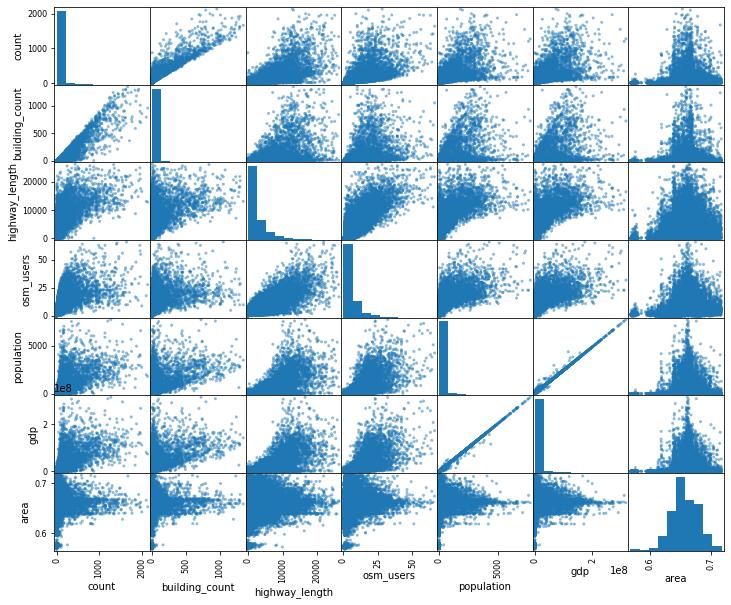

In [119]:
pd.plotting.scatter_matrix(df_model, figsize=(12, 10));

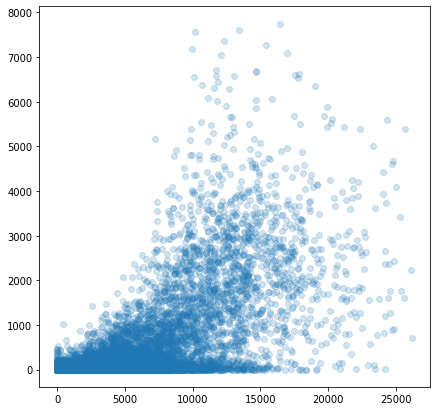

In [120]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df_model, x='highway_length', y='population', alpha=0.2);

As expected due to the high correlation, the distribution between `highway_residential_length` and `population` follows quite strongly a straight line, albeit with some outliers. 

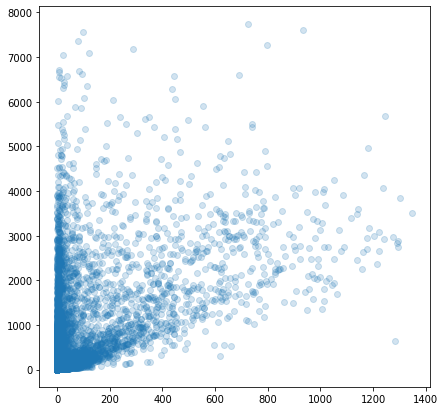

In [121]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df_model, x='building_count', y='population', alpha=0.2)

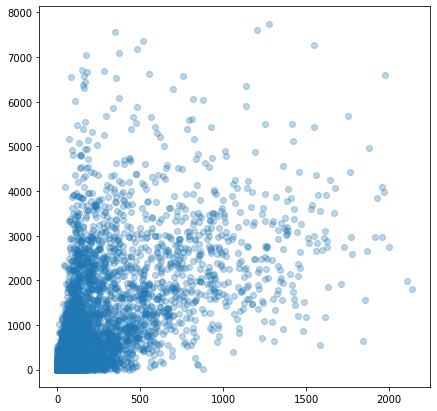

In [122]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df_model, x='count', y='population', alpha=0.3)

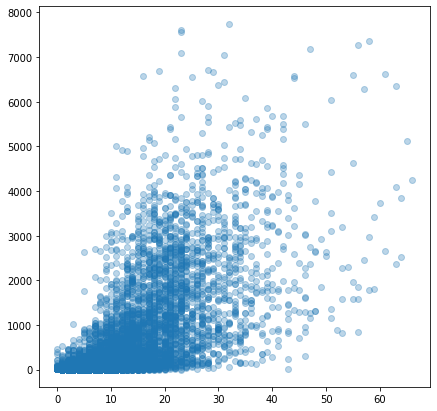

In [125]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df_model, x='osm_users', y='population', alpha=0.3)

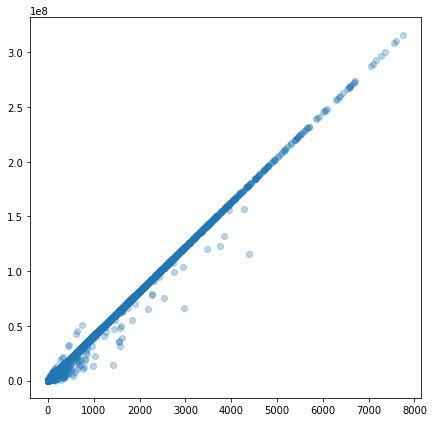

In [134]:
plt.figure(figsize=(7, 7))
plt.scatter(data=df_model, x='population', y='gdp', alpha=0.3)

We see from the plot above that the correlation between `gdp` and `population` is almost perfect, which means that the population is entirely explained by the variables `gdp`. Therefore, for this reaosn we shouldn't use `gdp` in our model to predict the population. Also, as we set out to make a model based solely on OSM features, including the `gdp` in our model would go against that.

<a id='helpers'></a>
## Helper Classes and Methods

In [126]:
def feature_mapping(x, order, intercept=False, only_self_terms=False):
    """
    Maps the original features up to the chosen degree.
    Example for initial features a and b and chosen order of 3:
    [a b a^2 ab b^2 a^3 a^2b ab^2 b^3]
    :param x: array like object of m examples by n features
    :param order: order of the polynomial expansion mapping to perform
    :param intercept: If return array should include the intercept column
    :param only_self_terms: if should only include polynomial terms (eg: x, x2, x3, etc)
    :return: array with mapped features
    """
    X = np.array(x).copy()

    n_features = X.shape[1] if len(X.shape) > 1 else 1
    features = [i for i in range(n_features)]

    for i in range(2, order + 1):

        if only_self_terms:

            for j in features:
                # X = np.hstack((X, X[:, j] ** i))
                X = np.c_[X, X[:, j] ** i]

        else:
            product_cases = list(product(features, repeat=i))

            product_cases = [tuple(sorted(t)) for t in product_cases]
            product_cases = list(set(product_cases))

            for case in product_cases:

                columns = np.array([x[:, int(col)] for col in case]).T
                columns_prod = np.cumprod(columns, axis=1)[:, -1].reshape(-1, 1)

                X = np.hstack((X, columns_prod))

    if intercept:
        X = np.c_[np.ones(X.shape[0]), X]

    return X

In [127]:
def plot_learning_curve(estimator, title, X, y, 
                        axes=None, ylim=None, cv=None,
                        n_jobs=-1, 
                        train_sizes=np.linspace(0.1, 1.0, 10),
                        metric='neg_mean_squared_error'
                       ):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(8, 18))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Error")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, 
                       scoring=metric
                      )
    
    train_scores = np.abs(train_scores)
    test_scores = np.abs(test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training error")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation error")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Error")
    axes[2].set_title("Performance of the model")

    return train_sizes, train_scores, test_scores, fit_times

In [128]:
class CalculateArea(BaseEstimator, TransformerMixin):
    
    def calculate_area(idx, poly):
                
        coords = [list(coord) for coord in poly.exterior.coords]
        
        poly = polygon([coords])
                
        return calculate_area(poly) / 1E6

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        
        X_copy = X.copy()
        
        if 'area' not in X.columns:
            X_copy['area'] = X_copy['geometry'].apply(lambda poly: self.calculate_area(poly))
                
        return X_copy

In [129]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        X_copy = X.copy()
        
        X_copy = X_copy[self.columns]
        
        return X_copy

In [130]:
class AreaNormalizer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        X_copy = X.copy()
        
        if 'area' in X:
            for col in X_copy:
                X_copy[col] = X_copy[col] / X_copy['area']
        
        return pd.DataFrame(X_copy)

In [131]:
class RemoveColumn(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        
        X_copy = X.drop(columns=self.columns)
        
        return X_copy

In [132]:
class FeaturePolynomial(BaseEstimator, TransformerMixin):
    
    def __init__(self, order, only_self_terms=True):
        self.order = order
        self.only_self_terms = only_self_terms
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        
        poly_X = feature_mapping(X.to_numpy(), self.order, only_self_terms=self.only_self_terms)
        
        return poly_X

<a id='ml'></a>
## Model Training

In this section we'll be fitting the data to the chosen regression algorithm. For that, we'll split the data in training and test examples, and build the machine learning pipeline. This chosen pipeline is a sequence of steps that encapsulates some transformations, some required and some optional. The main model design decision here was to normalize all features by the are corresponding area, as that proved to make the model generalize to larger areas much better. Below the steps of the pipeline are briefly described:

1. `calculate_area`: This step calculates the area of inut data if it is not calculated already
2. `feature_selector`: This step selects the model features + the `area`, as it will be used in the next step.
3. `area_normalizer`: This step normalizes each feature by the area corresponding to that input data.
4. `remove_columns`: This step removes unrequired columns; in this case `area`
5. `feature_mapping`: This step adds features which are the exponiented input features, up to a specified degree
6. `scaling`: This step scales the features by subtracting the mean and dividing by the standard deviation
7. `reg`: This step is when the regression happens, where the data is finally fitted into the chosen algorithm.

We can define our model variables as:

In [135]:
features = ['osm_users', 'count', 'building_count', 'highway_length']
target = 'population'

We divide the target variable (`population`) by the `area`, but leave the same process for the features as a step on the ML pipeline - the `AreaNormalizer` class.

In [174]:
X = df_model
y = df_model[target] / df_model['area']

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

We can define the pipeline as detailed above and do a first fitting of the data to get a sense of the results. We'll use as a first approach a **Lasso** Regressor:

In [176]:
pipeline = Pipeline([
    ('calculate_area', CalculateArea()),
    ('feature_selector', FeatureSelector(columns=[*features, 'area'])),
    ('area_normalizer', AreaNormalizer()),
    ('remove_columns', RemoveColumn(['area'])),
    ('feature_mapping', FeaturePolynomial(1)),
    ('pre-processing', StandardScaler()),
    ('reg', Lasso(alpha=2)),
])

In [177]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('calculate_area', CalculateArea()),
                ('feature_selector',
                 FeatureSelector(columns=['osm_users', 'count',
                                          'building_count', 'highway_length',
                                          'area'])),
                ('area_normalizer', AreaNormalizer()),
                ('remove_columns', RemoveColumn(columns=['area'])),
                ('feature_mapping',
                 FeaturePolynomial(only_self_terms=True, order=1)),
                ('pre-processing',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Lasso(alpha=2, copy_X=True, fit_intercept=True, max_iter=1000,
                       normalize=False, positive=False, precompute=False,
                       random_state=None, selection='cyclic', tol=0.0001,
                       warm_start=False))],
         verbose=False)

In [178]:
pipeline.score(X_test, y_test)

0.5885635457097993

Let's see if we can select better parameters to fine tune the model. We'll perform a hyperparameter tuning in order to fid the best combination of parameters for 2 different regressors, the **Lasso** and **Ridge** regressors.

In [179]:
params = {
    "feature_mapping__order": [1, 2, 3],
    "feature_mapping__only_self_terms": [True, False],
    "reg": [Lasso(), Ridge()],
    "reg__alpha": [1, 2, 3, 4, 5, 10, 50],
}

In [180]:
grid = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('calculate_area', CalculateArea()),
                                       ('feature_selector',
                                        FeatureSelector(columns=['osm_users',
                                                                 'count',
                                                                 'building_count',
                                                                 'highway_length',
                                                                 'area'])),
                                       ('area_normalizer', AreaNormalizer()),
                                       ('remove_columns',
                                        RemoveColumn(columns=['area'])),
                                       ('feature_mapping',
                                        FeaturePolynomial(only_self_...
                                       fit_interc

In [181]:
grid.best_score_

0.6611067849698828

In [182]:
grid.best_params_

{'feature_mapping__only_self_terms': False,
 'feature_mapping__order': 3,
 'reg': Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
       random_state=None, solver='auto', tol=0.001),
 'reg__alpha': 10}

We can see that the best combination of parameters is to use the **Ridge** regressor, a polynomial degree of `3`, use combinations of features (`only_self_terms` to False) and a regularization parameter (`alpha`) of 10. Let's fit the data using those parameters.

In [256]:
pipeline = Pipeline([
    ('calculate_area', CalculateArea()),
    ('feature_selector', FeatureSelector(columns=[*features, 'area'])),
    ('area_normalizer', AreaNormalizer()),
    ('remove_columns', RemoveColumn(['area'])),
    ('feature_mapping', FeaturePolynomial(3, False)),
    ('pre-processing', StandardScaler()),
    ('reg', Ridge(alpha=10)),
])

In [257]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('calculate_area', CalculateArea()),
                ('feature_selector',
                 FeatureSelector(columns=['osm_users', 'count',
                                          'building_count', 'highway_length',
                                          'area'])),
                ('area_normalizer', AreaNormalizer()),
                ('remove_columns', RemoveColumn(columns=['area'])),
                ('feature_mapping',
                 FeaturePolynomial(only_self_terms=False, order=3)),
                ('pre-processing',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
                       normalize=False, random_state=None, solver='auto',
                       tol=0.001))],
         verbose=False)

In [258]:
pipeline.score(X_test, y_test)

0.6665818990584536

We obtained a sizable improvement with the hypertuning, and went from a score of ~0.589 to ~0.667. We can look at the learning curves in order to get a sense of where we stand in relation to the bias-variance trade off.

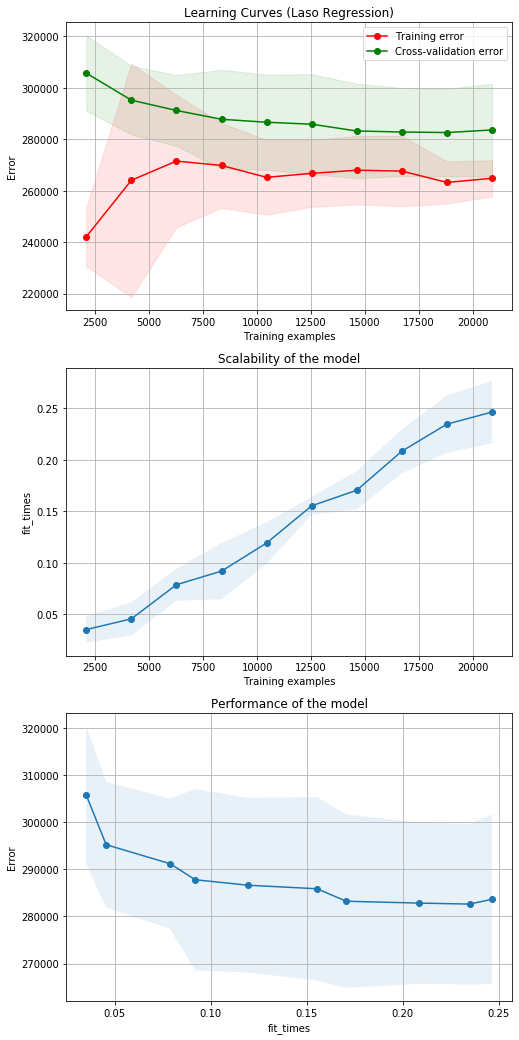

In [259]:
title = "Learning Curves (Ridge Regression)"

cv = ShuffleSplit(n_splits=3, test_size=0.3)

train_sizes, train_scores, test_scores, fit_times = plot_learning_curve(pipeline, title, X, y, cv=cv)

By looking at the learning curves we see that we are suffering mostly from bias in this model, as both the training and cross validation scores are relatively high and stabilize, even with more training examples. This points to the fact that perhaps we could improve our model by using more features describing the input space.

Let's try now other regressors, such as the **RandomForestRegressor** and the **GradientBoostingRegressor**, which, as opposed to the previous ones we used, are stochastic. As we did with the previous regressors, let's first try with some default values the **RandomForestRegressor** to get a sense of the results we get.

In [265]:
pipeline = Pipeline([
    ('calculate_area', CalculateArea()),
    ('feature_selector', FeatureSelector(columns=[*features, 'area'])),
    ('area_normalizer', AreaNormalizer()),
    ('remove_columns', RemoveColumn(['area'])),
    ('feature_mapping', FeaturePolynomial(1, False)),
    ('pre-processing', StandardScaler()),
    ('reg', RandomForestRegressor()),
])

In [194]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('calculate_area', CalculateArea()),
                ('feature_selector',
                 FeatureSelector(columns=['osm_users', 'count',
                                          'building_count', 'highway_length',
                                          'area'])),
                ('area_normalizer', AreaNormalizer()),
                ('remove_columns', RemoveColumn(columns=['area'])),
                ('feature_mapping',
                 FeaturePolynomial(only_self_terms=False, order=1)),
                ('pre-processing',
                 Stan...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=N

In [195]:
pipeline.score(X_test, y_test)

0.6572879479644563

The score using a **RandomForestRegressor** is out of the box almost as good as the previous regressors fine tuned. Let's perform hyperparameter tuning for these 2 regressors on the feature mapping step.

In [196]:
params = {
    'feature_mapping__order': [1, 2, 3],
    'feature_mapping__only_self_terms': [True, False],
    'reg': [RandomForestRegressor(), GradientBoostingRegressor()],
}

In [197]:
grid = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('calculate_area', CalculateArea()),
                                       ('feature_selector',
                                        FeatureSelector(columns=['osm_users',
                                                                 'count',
                                                                 'building_count',
                                                                 'highway_length',
                                                                 'area'])),
                                       ('area_normalizer', AreaNormalizer()),
                                       ('remove_columns',
                                        RemoveColumn(columns=['area'])),
                                       ('feature_mapping',
                                        FeaturePolynomial(only_self_...
                                                 

In [198]:
grid.best_score_

0.6734230712712861

In [199]:
grid.best_params_

{'feature_mapping__only_self_terms': False,
 'feature_mapping__order': 3,
 'reg': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False)}

We see that, again, the best parameters for the feature mapping are to use combinations of the features and a degree of `3`, and that the best regressor was the **GradientBoostingRegressor**. We can now perform hyperparameter tuning on other parameters of this regressor.

In [214]:
pipeline = Pipeline([
    ('calculate_area', CalculateArea()),
    ('feature_selector', FeatureSelector(columns=[*features, 'area'])),
    ('area_normalizer', AreaNormalizer()),
    ('remove_columns', RemoveColumn(['area'])),
    ('feature_mapping', FeaturePolynomial(3, False)),
    ('pre-processing', StandardScaler()),
    ('reg', GradientBoostingRegressor()()),
])

In [235]:
params = {
    'reg__max_leaf_nodes': [100, 200, None],
    'reg__n_estimators': [100, 200],
    'reg__max_features': ['auto', 'sqrt']
}

In [236]:
grid = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('calculate_area', CalculateArea()),
                                       ('feature_selector',
                                        FeatureSelector(columns=['osm_users',
                                                                 'count',
                                                                 'building_count',
                                                                 'highway_length',
                                                                 'area'])),
                                       ('area_normalizer', AreaNormalizer()),
                                       ('remove_columns',
                                        RemoveColumn(columns=['area'])),
                                       ('feature_mapping',
                                        FeaturePolynomial(only_self_...
                                                 

In [237]:
grid.best_score_

0.6760924048922343

In [238]:
grid.best_params_

{'reg__max_features': 'sqrt',
 'reg__max_leaf_nodes': 100,
 'reg__n_estimators': 100}

The best parameters are to use 100 estimators, a maximum of square root of the features and a maximum of 100 leaf nodes.

In [260]:
pipeline = Pipeline([
    ('calculate_area', CalculateArea()),
    ('feature_selector', FeatureSelector(columns=[*features, 'area'])),
    ('area_normalizer', AreaNormalizer()),
    ('remove_columns', RemoveColumn(['area'])),
    ('feature_mapping', FeaturePolynomial(3, False)),
    ('pre-processing', StandardScaler()),
    ('reg', GradientBoostingRegressor(n_estimators=100, max_features='sqrt')),
])

In [261]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('calculate_area', CalculateArea()),
                ('feature_selector',
                 FeatureSelector(columns=['osm_users', 'count',
                                          'building_count', 'highway_length',
                                          'area'])),
                ('area_normalizer', AreaNormalizer()),
                ('remove_columns', RemoveColumn(columns=['area'])),
                ('feature_mapping',
                 FeaturePolynomial(only_self_terms=False, order=3)),
                ('pre-processing',
                 Stan...
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features='sqrt',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_sample

In [262]:
pipeline.score(X_test, y_test)

0.674888251192042

This score of ~0.67 is an improvement over using linear models. Let's look also at the learning curves for this model.

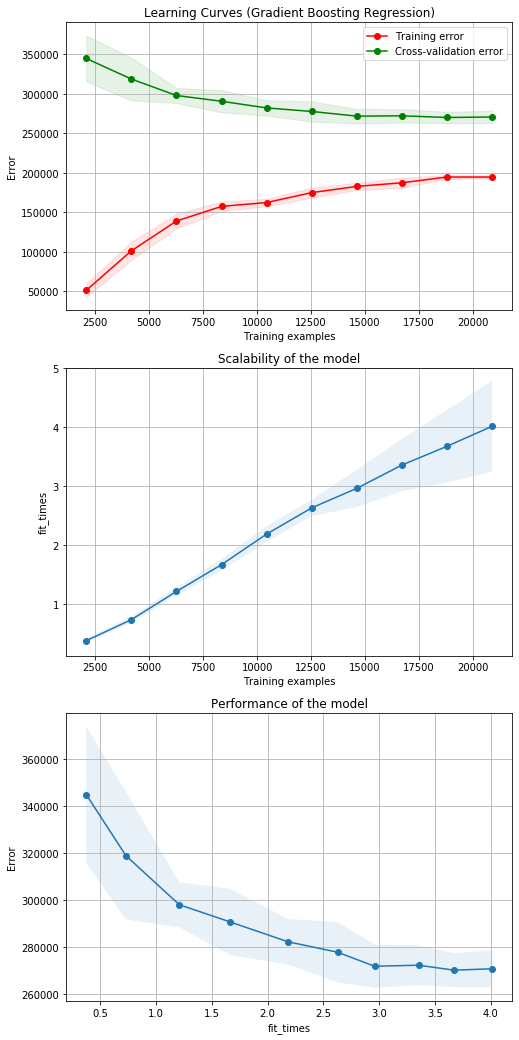

In [263]:
title = "Learning Curves (Gradient Boosting Regression)"

cv = ShuffleSplit(n_splits=3, test_size=0.3)

train_sizes, train_scores, test_scores, fit_times = plot_learning_curve(pipeline, title, X, y, cv=cv)

We see also that we are again suffering from a certain high bias. Although probably the cross validation error would decrease with more data in the model, it would only be able to converge to the minimum error on the training data, which is roughly 200k. This also shows that very likely adding more features would help us create a model with more variance and make better predictions.

<a id="conclusion"></a>
## Conclusion

In this notebook we set out to build a population prediction model, based solely on OSM data features. For this, we used as training data a dataset [1] composed of roughly equally sized hexagons, spread across the UK. Each of these input data points contained features such as the total count, building count, number of OSM users that compiled that data, and the total road (highway) length, as well the target variable of study - the population. There were some other features present, but as there was some uncertainty as to what they actually represented and doubts that those could be taken from OSM files, they were left out of the model.

The results of this exploration / analysis were satisfactory as a first step, but the learning curves showed that the model suffers from high bias whether we use linear or ensemble models, although for the latter case, it is liekly that if we used more data we would perform better, even if the extra data required could be quite large. To solve the high bias problem we can add more features to the input space. From the current dataset we would not be able to extract more OSM features, so we'd have to create our own feature extraction method in order to enrich the data. This is what was done [here](https://github.com/diogomatoschaves/osm-feature-extractor), and we'll explore the results from this enriched dataset in the follow-up notebook [`all_features.ipynb`](./all_features.ipynb).



<a id='references'></a>
## References

[1] - [Kontur Population: Global Population Density for 400m H3 Hexagons](https://data.humdata.org/dataset/kontur-population-dataset) <br>